In [7]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers


import pathlib
import os
import zipfile

from io import BytesIO
import PIL.Image
import ipywidgets as widgets
from IPython.display import display

## Import des données et séparation des classes

### Vérification de l'import de bon format de fichiers

In [8]:
import os

data_dir_train = "/Users/victorouledi/Documents/2024-2025/CNN/data/train"
data_dir_test = "/Users/victorouledi/Documents/2024-2025/CNN/data/test"

# Liste des extensions de fichiers autorisées
allowed_extensions = {'.jpeg', '.jpg', '.png', '.gif', '.bmp'}

def detect_non_image_files(directory):
    non_image_files = []  # Liste pour stocker les chemins des fichiers non image
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Vérifier l'extension du fichier
            if not any(file.lower().endswith(ext) for ext in allowed_extensions):
                file_path = os.path.join(root, file)
                non_image_files.append(file_path)  # Ajouter à la liste
    return non_image_files

# Détecter les fichiers non image dans les deux répertoires
non_image_train_files = detect_non_image_files(data_dir_train)
non_image_test_files = detect_non_image_files(data_dir_test)

# Afficher et supprimer les fichiers non image détectés
if non_image_train_files:
    print("Fichiers non image dans le répertoire d'entraînement :")
    for file in non_image_train_files:
        print(file)
        os.remove(file)  # Supprimer le fichier non image
        print(f"Supprimé : {file}")

if non_image_test_files:
    print("Fichiers non image dans le répertoire de test :")
    for file in non_image_test_files:
        print(file)
        os.remove(file)  # Supprimer le fichier non image
        print(f"Supprimé : {file}")

if not non_image_train_files and not non_image_test_files:
    print("Aucun fichier non autorisé détecté dans les répertoires.")


Fichiers non image dans le répertoire d'entraînement :
/Users/victorouledi/Documents/2024-2025/CNN/data/train/.DS_Store
Supprimé : /Users/victorouledi/Documents/2024-2025/CNN/data/train/.DS_Store
/Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_99
Supprimé : /Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_99
/Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_52
Supprimé : /Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_52
/Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_55
Supprimé : /Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_55
/Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_63
Supprimé : /Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_63
/Users/victorouledi/Documents/2024-2025/CNN/data/train/Poumon/.DS_Store_copy_64
Supprimé : /Users/victorouledi/Documents

In [9]:
# Chemin vers le dossier contenant le dataset
data_dir_train = "/Users/victorouledi/Documents/2024-2025/CNN/data/train"
data_dir_test = "/Users/victorouledi/Documents/2024-2025/CNN/data/test"

# Vérification du chemin des données
data_dir_train = pathlib.Path(data_dir_train)
data_dir_test = pathlib.Path(data_dir_test)

# Paramètres de traitement des images
batch_size = 30
img_height = 200
img_width = 200

# Ensemble d'entraînement
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Ensemble de validation
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.4,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Afficher les noms des classes
class_names = val_data.class_names
print("Classes :", class_names)


Found 23477 files belonging to 3 classes.
Using 18782 files for training.
Found 10537 files belonging to 3 classes.
Using 4214 files for validation.
Classes : ['Autres', 'Cerveau', 'Poumon']


## Visualisation 

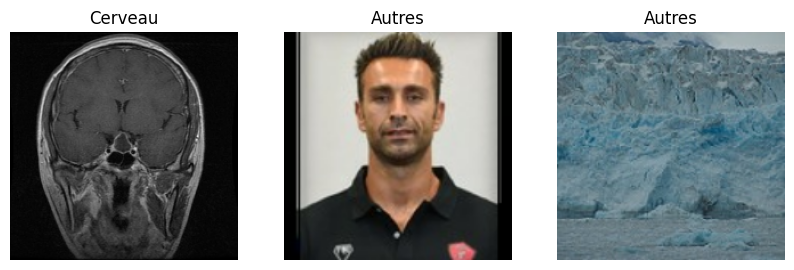

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Ajustement du modèle 


- Normalisation de la taille des images 

- Différentes couches de convolution 2D avec 128, 64, 32, et 16 filtres de taile 4X4 

- Rajout de couche de maxpooling à chaque fois pour résumer les features maps obtenue par les couches de concolutions

- Rajout d'une couche  Flatten qui réduit la dimension des features maps en un vecteur pour simplification d'apprentissage

- Rajout de couche dense avec 64 neuronnes pour apprentissage des informations tirées des couhces de convultion, de pooling et de la couche Flatten.

- Dernière couche à 2 neuronnes retournant la probabilité qu'une image appartienne à une classe ou l'autre. 

- Entrainement du modèe sur 3 époques



In [11]:
# Répertoire temporaire avec permissions d'écriture des logs
logdir = "/tmp/logs"  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True)

num_classes = 3

#Création du modèle
model = tf.keras.Sequential([
    layers.Rescaling(1./255),  
    layers.Conv2D(128, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compliation du modèle, définition de la fonction de coût (ici adapté aux problèmes de classification) avec spécifiaction sous forme de logit binomiale retraduit par la fonction soft max en proba
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Entrainement du modèle sur 3 époques 
model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    callbacks=[tensorboard_callback]
)



Epoch 1/3
627/627 ━━━━━━━━━━━━━━━━━━━━ 965s 2s/step - accuracy: 0.9025 - loss: 0.3034 - val_accuracy: 0.9803 - val_loss: 0.0647
Epoch 2/3
627/627 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - accuracy: 0.9924 - loss: 0.0259 - val_accuracy: 0.9808 - val_loss: 0.1132
Epoch 3/3
627/627 ━━━━━━━━━━━━━━━━━━━━ 971s 2s/step - accuracy: 0.9924 - loss: 0.0259 - val_accuracy: 0.9881 - val_loss: 0.0696


## Résumé du modèle

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 197, 197, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 98, 98, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 95, 95, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 19, 19, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        83,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,859 (2.99 MB)

 Trainable params: 261,619 (1021.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 523,240 (2.00 MB)

### Test de prédiction du modèle

In [13]:
import numpy as np
import cv2

# Import image
image_path = "/Users/victorouledi/Downloads/poumon4.jpeg"  # Remplace par le chemin de ton image

image_to_predict = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image_to_predict is not None:
    # Prétraiter l'image pour la prédiction
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict, (img_width, img_height)), axis=0)
    
    # Prédictions avec le modèle
    predictions = model.predict(img_to_predict)[0]  # Récupère directement la première prédiction
    
    # Trier les indices des classes par ordre de probabilité décroissante
    sorted_indices = np.argsort(predictions)[::-1]
    
    # Obtenir la première classe et sa confiance
    top_class_index = sorted_indices[0]
    top_class_confidence = predictions[top_class_index]
    
    # Vérifier la confiance est suffisante pour prédire la classe (utile pour palier au problème où  pour lesquels les imageries  de poumons ou du cerveaus moins conventionnelles auront tendences à être prédites comme autres avec une certitude moins importante )
    if top_class_confidence >= 0.90:
        predicted_class_index = top_class_index
    else:
        # Prendre la deuxième classe si la première est en dessous du seuil
        predicted_class_index = sorted_indices[1]
    
    # Obtenir le nom de la classe prédite
    predicted_class_name = class_names[predicted_class_index]
    
    # Afficher le résultat
    print(f"L'image est prédite comme : {predicted_class_name} avec une confiance de {predictions[predicted_class_index]:.2f}")
else:
    print("Erreur lors du chargement de l'image. Vérifiez le chemin d'accès.")



Erreur lors du chargement de l'image. Vérifiez le chemin d'accès.


[ WARN:0@3375.952] global loadsave.cpp:241 findDecoder imread_('/Users/victorouledi/Downloads/poumon4.jpeg'): can't open/read file: check file path/integrity


## Sauvegarde

In [14]:
chemin_dossier = "/Users/victorouledi/Documents/2024-2025/CNN/"  

model.save(chemin_dossier + "CNN_imageries_medicales2.h5")
